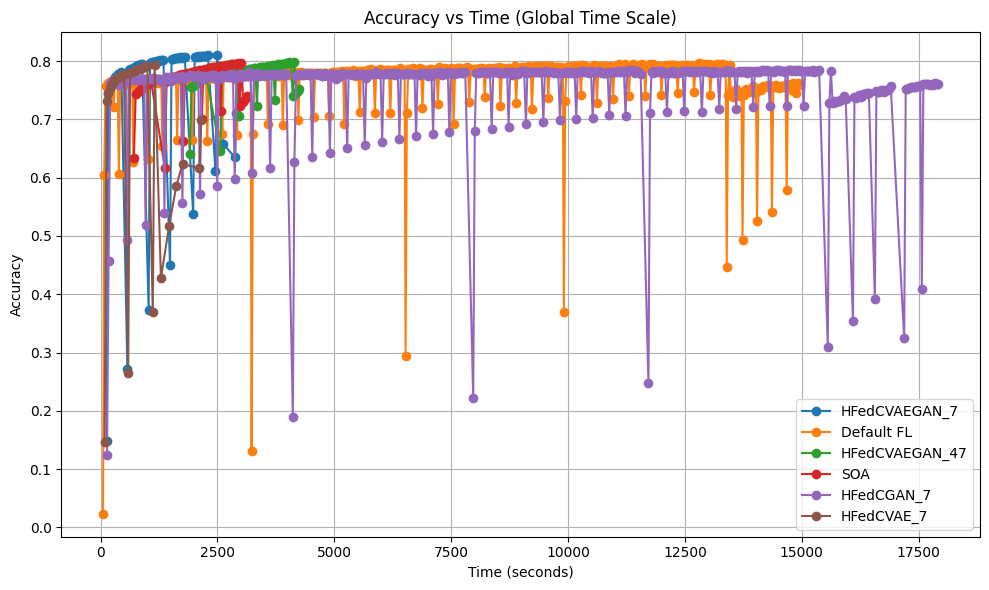

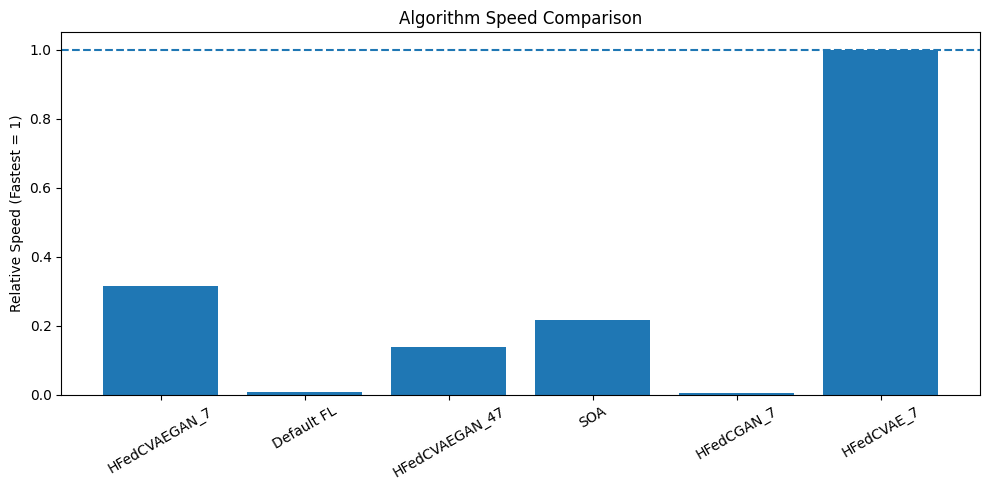

In [21]:
import os
import json
import ast
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

# =========================
# CONFIG
# =========================
DATA_DIR = "../src/plots"
NAME_MAP_FILE = "algorithm_names.json"
target_accuracy = 0.794


# =========================
# HELPERS
# =========================
def load_dict(filepath):
    with open(filepath, "r") as f:
        content = f.read()
        try:
            return json.loads(content)
        except json.JSONDecodeError:
            return ast.literal_eval(content)


def parse_filename(filename):
    """
    default_5_7_claudiogsc_emnist_balanced_results
    returns:
    algo=default, clients=5, classes=7
    """
    parts = filename.split("_")
    return parts[0], int(parts[1]), int(parts[2])


# =========================
# COLLECT FILES
# =========================
results_files = {}
round_time_files = {}

for file in os.listdir(DATA_DIR):
    if file.endswith("_results.json"):
        key = file.replace("_results.json", "")
        results_files[key] = os.path.join(DATA_DIR, file)
    elif file.endswith("_round_times.json"):
        key = file.replace("_round_times.json", "")
        round_time_files[key] = os.path.join(DATA_DIR, file)

common_keys = set(results_files.keys()) & set(round_time_files.keys())

# =========================
# PROCESS DATA
# =========================
algo_data = {}

for key in common_keys:
    algo, clients, classes = parse_filename(key)

    unique_algo_key = f"{algo}_{classes}"  # IMPORTANT CHANGE

    results = load_dict(results_files[key])
    times = load_dict(round_time_files[key])

    round_acc = defaultdict(list)

    for client_id, rounds in results.items():
        for rnd, data in rounds.items():
            if data["metrics"]["accuracy"] >= target_accuracy:
                round_acc[rnd].append(data["metrics"]["accuracy"])
                continue
            round_acc[rnd].append(data["metrics"]["accuracy"])

    rounds_sorted = sorted(round_acc.keys())

    avg_accuracy = []
    avg_time = []
    cumulative_time = 0

    for rnd in rounds_sorted:
        avg_accuracy.append(np.mean(round_acc[rnd]))
        cumulative_time += times[rnd]
        avg_time.append(cumulative_time)

    algo_data[unique_algo_key] = {
        "algo": algo,
        "clients": clients,
        "classes": classes,
        "accuracy": np.array(avg_accuracy),
        "time": np.array(avg_time),
    }

# =========================
# AUTO-MAINTAIN JSON FILE
# =========================
current_keys = set(algo_data.keys())

if not os.path.exists(NAME_MAP_FILE):
    # Create file initially
    name_map = {k: k for k in current_keys}
else:
    with open(NAME_MAP_FILE, "r") as f:
        name_map = json.load(f)

    # Remove stale entries
    for k in list(name_map.keys()):
        if k not in current_keys:
            del name_map[k]

    # Add missing entries
    for k in current_keys:
        if k not in name_map:
            name_map[k] = k

with open(NAME_MAP_FILE, "w") as f:
    json.dump(name_map, f, indent=4)

# =========================
# GLOBAL TIME AXIS
# =========================
max_round_time = max(
    np.max(data["time"]) for data in algo_data.values() if len(data["time"]) > 0
)

# =========================
# GRAPH 1 – Accuracy vs Time (GLOBAL SCALE)
# =========================
plt.figure(figsize=(10, 6))

for key, data in algo_data.items():
    label = name_map[key]

    # Each round plotted at its own time^2
    x = data["time"]
    y = data["accuracy"]

    plt.plot(x, y, marker="o", label=label)

plt.xlabel("Time (seconds)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Time (Global Time Scale)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# =========================
# GRAPH 2 – SPEED COMPARISON
# =========================
speed_scores = {}

for key, data in algo_data.items():
    total_time = data["time"].sum()
    final_acc = data["accuracy"][-1]
    speed_scores[key] = final_acc / total_time

fastest_key = max(speed_scores, key=speed_scores.get)
fastest_speed = speed_scores[fastest_key]

labels = []
relative_speeds = []

for key, speed in speed_scores.items():
    labels.append(name_map[key])
    relative_speeds.append(speed / fastest_speed)

plt.figure(figsize=(10, 5))
plt.bar(labels, relative_speeds)
plt.axhline(1.0, linestyle="--")

plt.ylabel("Relative Speed (Fastest = 1)")
plt.title("Algorithm Speed Comparison")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()